In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import glob
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:

# 定义 RNN 回归模型
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out



# 定义自定义的准确率函数
def calculate_custom_accuracy(predictions, targets, tolerance=0.5):
    predictions = predictions#.detach().cpu().numpy()
    targets = targets#.detach().cpu().numpy()
    correct = np.abs(predictions - targets) < tolerance
    accuracy = np.mean(correct)
    return accuracy


# 定义保存模型的函数
def save_checkpoint(model, optimizer, epoch, val_accuracy, val_loss, file_path):
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_accuracy': val_accuracy,
        'val_loss': val_loss
    }
    torch.save(checkpoint, file_path)

def read_data(user_list, round_list):
  file_pattern = '../../dataset/dataset_txt/p*.txt'
  files = glob.glob(file_pattern)
  real_parts = []
  imaginary_parts = []
  pinch_pressure = []
  user_ids = []
  data = {
      'Real Parts': real_parts,
      'Imaginary Parts': imaginary_parts,
      'Pinch Pressure': pinch_pressure,
      'User ID': user_ids  # Assuming each file corresponds to a different user
  }


  for file in files:
    user_id = int(os.path.basename(file).split('-')[0][1:])
    round_id = int(os.path.basename(file).split('-')[-1][:1])

    if user_id not in user_list:
      continue
    if round_id not in round_list:
       continue
    print(file)
    with open(file, mode='r') as f:
        lines = f.readlines()

        for i in range(4, len(lines), 4):
            if 'frame' in lines[i]:
                real_parts.append([float(val) for val in lines[i+1].strip().split()])
                imaginary_parts.append([float(val) for val in lines[i+2].strip().split()])
                pinch_pressure.append(float(lines[i+3].strip().split()[0]))
                user_ids.append(user_id)  # Assigning the user ID to each data point

  # Create a DataFrame
  df = pd.DataFrame(data)
  X = np.hstack((df['Real Parts'].tolist(), df['Imaginary Parts'].tolist()))
  # X = X.reshape(-1, 2, 6)
  y = df['Pinch Pressure'].values

  return X, y 


In [6]:
X_train, y_train = read_data(list(range(1,21)),list([2]))
# X_val, y_val = read_data(list(range(1,21)),list(range(3,4)))
filename = 'combine20_r1r2train_r3valid'

../../dataset/dataset_txt/p6-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p1-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p19-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p7-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p2-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p14-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p10-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p12-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p4-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p18-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p5-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p17-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p15-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p11-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p16-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p20-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p13-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p9-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p3-50kHz-1mA-6m-2.txt
../../dataset/dataset_txt/p8-50kHz-1mA-6m-2.txt


In [27]:

# Read Data
X_train, y_train = read_data(list(range(1,21)),list(range(1,3)))
X_val, y_val = read_data(list(range(1,21)),list(range(3,4)))
filename = 'combine20_r1r2train_r3valid'

mean = np.mean(X_train, axis=0, keepdims=True)
std = np.std(X_train, axis=0, keepdims=True)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')



saveModel_dir = f'../../savedModel/{filename}'
os.makedirs(saveModel_dir, exist_ok=True)
results_dir = f'../../saveResult/{filename}'
os.makedirs(results_dir, exist_ok=True)
saveplot_dir = f'../../savePlot/{filename}'
os.makedirs(saveplot_dir, exist_ok=True)


# 假设 X_train, y_train, X_val, y_val, X_test, y_test 数据已经存在
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# 将数据转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# 数据归一化
mean = X_train_tensor.mean(dim=0, keepdim=True)
std = X_train_tensor.std(dim=0, keepdim=True)
X_train_tensor = (X_train_tensor - mean) / std
X_val_tensor = (X_val_tensor - mean) / std

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
# learning_rates = [ 1e-2, 1e-3, 1e-4, 1e-5]
learning_rates = [  1e-3 ]
num_epochs = 10000

results = {}

# 定义保存模型的目录



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

X_train shape: (65630, 12)
y_train shape: (65630,)
X_val shape: (34344, 12)
y_val shape: (34344,)
cpu


In [28]:
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = RNNModel(input_dim=12, hidden_dim=128, output_dim=1, num_layers=2).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0.0
    best_val_accuracy_epoch = 0
    lowest_val_loss = float('inf')
    lowest_val_loss_epoch = 0
    best_train_accuracy = 0.0
    best_train_accuracy_epoch = 0
    lowest_train_loss = float('inf')
    lowest_train_loss_epoch = 0
    train_output_result = []
    train_true_result = []
    val_output_result = []
    val_true_result = []
    for epoch in tqdm(range(num_epochs), desc=f"Learning Rate {lr}"):
        model.train()
        running_loss = 0.0
        all_predictions_train = []
        all_labels_train = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            inputs = inputs.unsqueeze(1)  # 调整维度为 (batch_size, seq_length, input_dim)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels.unsqueeze(1))  # 将标签调整为 (batch_size, 1)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            all_predictions_train.append(outputs.detach().cpu().numpy())
            all_labels_train.append(labels.unsqueeze(1).detach().cpu().numpy())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        all_predictions_train = np.concatenate(all_predictions_train, axis=0)
        all_labels_train = np.concatenate(all_labels_train, axis=0)

        train_output_result.append(all_predictions_train)
        train_true_result.append(all_labels_train)

        train_accuracy = calculate_custom_accuracy(all_predictions_train, all_labels_train, tolerance=0.5)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                inputs = inputs.unsqueeze(1)  # 调整维度为 (batch_size, seq_length, input_dim)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))  # 将标签调整为 (batch_size, 1)
                val_loss += loss.item() * inputs.size(0)
                
                all_predictions.append(outputs.detach().cpu().numpy())
                all_labels.append(labels.unsqueeze(1).detach().cpu().numpy())
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        all_predictions = np.concatenate(all_predictions, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        val_output_result.append(all_predictions)
        val_true_result.append(all_labels)

        val_accuracy = calculate_custom_accuracy(all_predictions, all_labels, tolerance=0.5)
        val_accuracies.append(val_accuracy)
        
        # 记录最好的准确率和最低的损失
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_val_accuracy_epoch = epoch + 1
            # 保存模型
            save_checkpoint(model, optimizer, epoch + 1, val_accuracy, val_loss, os.path.join(saveModel_dir, f"best_val_accuracy_lr_{lr}.pt"))
        
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            lowest_val_loss_epoch = epoch + 1
            # 保存模型
            save_checkpoint(model, optimizer, epoch + 1, val_accuracy, val_loss, os.path.join(saveModel_dir, f"lowest_val_loss_lr_{lr}.pt"))
        
        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy
            best_train_accuracy_epoch = epoch + 1
            # 保存模型
            save_checkpoint(model, optimizer, epoch + 1, train_accuracy, epoch_loss, os.path.join(saveModel_dir, f"best_train_accuracy_lr_{lr}.pt"))
        
        if epoch_loss < lowest_train_loss:
            lowest_train_loss = epoch_loss
            lowest_train_loss_epoch = epoch + 1
            # 保存模型
            save_checkpoint(model, optimizer, epoch + 1, train_accuracy, epoch_loss, os.path.join(saveModel_dir, f"lowest_train_loss_lr_{lr}.pt"))

    results[lr] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_accuracy': best_val_accuracy,
        'best_val_accuracy_epoch': best_val_accuracy_epoch,
        'lowest_val_loss': lowest_val_loss,
        'lowest_val_loss_epoch': lowest_val_loss_epoch,
        'best_train_accuracy': best_train_accuracy,
        'best_train_accuracy_epoch': best_train_accuracy_epoch,
        'lowest_train_loss': lowest_train_loss,
        'lowest_train_loss_epoch': lowest_train_loss_epoch,
        'train_output_result': train_output_result,
        'train_true_result': train_true_result,
        'val_output_result': val_output_result,
        'val_true_result': val_true_result
    }

# 创建保存图片的目录

Training with learning rate: 0.001


Learning Rate 0.001:   0%|          | 1/10000 [00:10<30:28:47, 10.97s/it]


KeyboardInterrupt: 

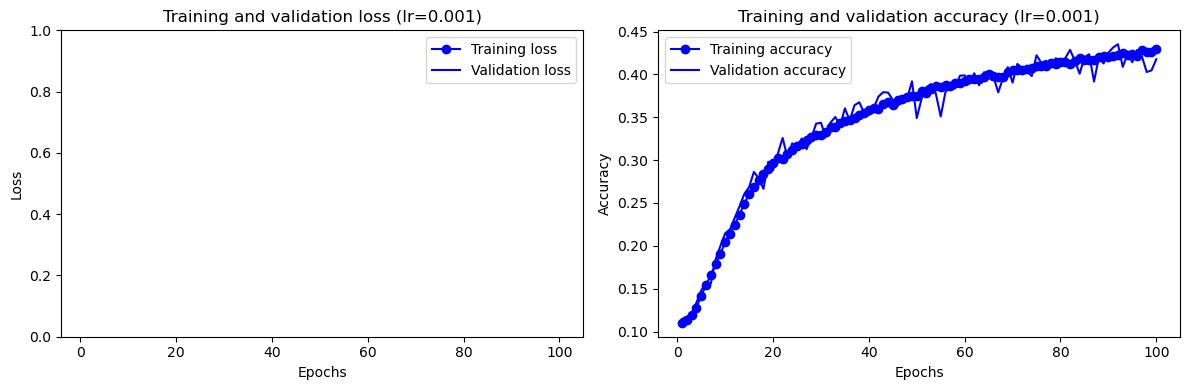

Results saved to ../../saveResult/combine20_8train_2valid/training_results.txt
Learning rate: 0.001
Best Validation Accuracy: 0.4352 at epoch 92
Lowest Validation Loss: 1.8010 at epoch 91
Best Training Accuracy: 0.4301 at epoch 100
Lowest Training Loss: 1.7658 at epoch 100




In [ ]:
for lr, result in results.items():
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, result['train_losses'], 'bo-', label='Training loss')
    plt.plot(epochs, result['val_losses'], 'b-', label='Validation loss')
    plt.title(f'Training and validation loss (lr={lr})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1.0)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, result['train_accuracies'], 'bo-', label='Training accuracy')
    plt.plot(epochs, result['val_accuracies'], 'b-', label='Validation accuracy')
    plt.title(f'Training and validation accuracy (lr={lr})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    
    # 保存图片
    plot_filename = os.path.join(saveplot_dir, f'training_validation_lr_{lr}.png')
    plt.savefig(plot_filename)
    
    # 显示图片
    plt.show()
# 定义保存文件的路径
results_file = 'training_results.txt'

os.makedirs(results_dir, exist_ok=True)
# 打开文件写入模式
with open(f'{results_dir}/{results_file}', 'w') as f:
    for lr, result in results.items():
        f.write(f"Learning rate: {lr}\n")
        f.write(f"Best Validation Accuracy: {result['best_val_accuracy']:.4f} at epoch {result['best_val_accuracy_epoch']}\n")
        f.write(f"Lowest Validation Loss: {result['lowest_val_loss']:.4f} at epoch {result['lowest_val_loss_epoch']}\n")
        f.write(f"Best Training Accuracy: {result['best_train_accuracy']:.4f} at epoch {result['best_train_accuracy_epoch']}\n")
        f.write(f"Lowest Training Loss: {result['lowest_train_loss']:.4f} at epoch {result['lowest_train_loss_epoch']}\n")
        f.write("\n")

print(f"Results saved to {results_dir}/{results_file}")

for lr, result in results.items():
    print(f"Learning rate: {lr}")
    print(f"Best Validation Accuracy: {result['best_val_accuracy']:.4f} at epoch {result['best_val_accuracy_epoch']}")
    print(f"Lowest Validation Loss: {result['lowest_val_loss']:.4f} at epoch {result['lowest_val_loss_epoch']}")
    print(f"Best Training Accuracy: {result['best_train_accuracy']:.4f} at epoch {result['best_train_accuracy_epoch']}")
    print(f"Lowest Training Loss: {result['lowest_train_loss']:.4f} at epoch {result['lowest_train_loss_epoch']}")
    print("\n")
